## Phase 2 Final Project Submission

* Student name: Jason Lombino
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: Matt Carr

<hr>

<h1>Business Problem</h1>

The mortgage department at Bentley & Co. Bank of Seattle is looking for an additional method of appraising the value of homes. They currently hire an appraisal management company, and will continue to do so. However, as independant appraisals can be costly and take time, Bentley & Co. Bank is looking for a tool that can estimate the value of a house cheaply and quickly.

 This will be useful for obtaining a ballpark estimate of the value of a home before an appraisal can be performed. In addition, it will be useful for estimating the price impact of any renovations performed on a house Bentley & Co. Bank has an interest in without any additional appraisals.

This tool must meet two criteria to be of use to Bentley & Co. Bank:
<ol>
<li>The tool must be capable of accurately predicting the price of a house provided information about the house.</li>
<li>The tool must provide insight into what factors impact the price of a house the most.</li>
</ol>

<hr>

<h1>Goals</h1>

Bentley Bank & Co. can use the models created in this notebook to:
* Generate a range of prices that the price of a given house can be expected to fall within. 
* Predict the price impact of any physical changes to a home.

<hr>

<h1>Imports & Important Functions<h2>

In [35]:
# Import necessary modules

import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

# Set important global options
%matplotlib inline
plt.style.use('seaborn')
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.3f}'.format

I made the following function to answer my business problem. It uses the best model to get a range of prices for any given house.

In [36]:
# This can not be run until the model sm_best is created in memory
def predict_interval(house,confidence=0.001):
    # Calculates predicted value and confidence interval of specified alpha
    prediction = np.exp(sm_best.get_prediction(house).predicted_mean[0])
    conf_interval = np.exp(sm_best.get_prediction(house).conf_int(alpha=confidence)[0])

    # Formats everything nicely
    pred_statement = f'This house has a predicted value of ${math.trunc(prediction)}.'
    interval_statement = (f'A safe value for this house would fall between '
        f'${math.trunc(conf_interval[0])} and ${math.trunc(conf_interval[1])}.')

    print(pred_statement)
    print(interval_statement)
    return(prediction)

# This can not be run until the model sm_best is created in memory
#predict_interval(X_test_best.iloc[42]);

I prefer SKLearn to statsmodels so I created a helper function to extract all of the relevant information from an SKLearn regression.

In [37]:
# The following function returns the results of a sklearn model
def model_summary(model,train_X,test_X,train_y,test_y):
    #Evaluates the model on training data
    train_r2 = model.score(train_X,train_y)
    train_mae = mean_absolute_error(train_y,model.predict(train_X))
    train_mse = mean_squared_error(train_y,model.predict(train_X))
    train_rmse = mean_squared_error(train_y,model.predict(train_X),squared=False)

    #Evaluates the model on test data
    test_r2 = model.score(test_X,test_y)
    test_mae = mean_absolute_error(test_y,model.predict(test_X))
    test_mse = mean_squared_error(test_y,model.predict(test_X))
    test_rmse = mean_squared_error(test_y,model.predict(test_X),squared=False)
    
    # Prepare the results to be added to a dataframe
    labels = ['Train R2','Train Mean Abs Err','Train Mean Sq Err','Train Root Mean Sq Err',
            'Test R2','Test Mean Abs Err','Test Mean Sq Err','Test Root Mean Sq Err']
    results = [train_r2,train_mae,train_mse,train_rmse,
            test_r2,test_mae,test_mse,test_rmse]
    
    #Return the results as pandas dataframes
    dfr = pd.DataFrame(results,index=labels,columns=['Values'])
    coefficients = pd.DataFrame(model.coef_,index=train_X.columns,columns=['Values'])
    return dfr,coefficients

<hr>

<h1>Data Understanding</h1>

The data provided in 'kc_house_data.csv' contains information on 21 thousand homes sold in the King County, WA area between 2014 and 2015. 

The data provided in 'zips.csv' contains a list of zipcodes and the corresponding city for each zipcode in King County, WA.

I began by loading each dataset into dataframes, dropping most of the columns suggested by the project description, and merging the two datasets together by the zipcode column.

In [38]:
# Homes contains data on home sales, zipcodes is for encoding cities later
homes = pd.read_csv('data/kc_house_data.csv')
zipcodes = pd.read_csv('data/zips.csv')

# Columns suggested to drop by project description
cols_to_drop = (['id','date','sqft_above','sqft_basement',
                'lat','long','sqft_living15','sqft_lot15'])
homes = homes.drop(cols_to_drop,axis=1)

# Exchange the zipcode column for a city column based on zipcode
homes = homes.merge(zipcodes,how='left',on='zipcode').drop('zipcode',axis=1)

# Overview of the data
homes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         21597 non-null  float64
 1   bedrooms      21597 non-null  int64  
 2   bathrooms     21597 non-null  float64
 3   sqft_living   21597 non-null  int64  
 4   sqft_lot      21597 non-null  int64  
 5   floors        21597 non-null  float64
 6   waterfront    19221 non-null  object 
 7   view          21534 non-null  object 
 8   condition     21597 non-null  object 
 9   grade         21597 non-null  object 
 10  yr_built      21597 non-null  int64  
 11  yr_renovated  17755 non-null  float64
 12  city          21597 non-null  object 
dtypes: float64(4), int64(4), object(5)
memory usage: 2.3+ MB


In [39]:
# Quick statistics on the data
homes.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated
count,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,17755.000
mean,540296.574,3.373,2.116,2080.322,15099.409,1.494,1971.000,83.637
std,367368.140,0.926,0.769,918.106,41412.637,0.540,29.375,399.946
min,78000.000,1.000,0.500,370.000,520.000,1.000,1900.000,0.000
25%,322000.000,3.000,1.750,1430.000,5040.000,1.000,1951.000,0.000
50%,450000.000,3.000,2.250,1910.000,7618.000,1.500,1975.000,0.000
75%,645000.000,4.000,2.500,2550.000,10685.000,2.000,1997.000,0.000
max,7700000.000,33.000,8.000,13540.000,1651359.000,3.500,2015.000,2015.000


In [40]:
# Quick overview of the data
homes.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,city
0,221900.000,3,1.000,1180,5650,1.000,NaN,NONE,Average,7 Average,1955,0.000,Seattle
1,538000.000,3,2.250,2570,7242,2.000,NO,NONE,Average,7 Average,1951,1991.000,Seattle
2,180000.000,2,1.000,770,10000,1.000,NO,NONE,Average,6 Low Average,1933,nan,Kenmore
3,604000.000,4,3.000,1960,5000,1.000,NO,NONE,Very Good,7 Average,1965,0.000,Seattle
4,510000.000,3,2.000,1680,8080,1.000,NO,NONE,Average,8 Good,1987,0.000,Sammamish


<hr>

<h1>Data Cleanup & Pre-processing</h1>

Not too much looks weird here, but the homes.describe() shows that at least one home has 33 bedrooms. Let's investigate this further.

In [41]:
homes[homes.bedrooms > 8]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,city
4092,599999.000,9,4.500,3830,6988,2.500,NO,NONE,Average,7 Average,1938,0.000,Seattle
4231,700000.000,9,3.000,3680,4400,2.000,NO,NONE,Average,7 Average,1908,0.000,Seattle
6073,1280000.000,9,4.500,3650,5000,2.000,NO,NONE,Average,8 Good,1915,2010.000,Seattle
8537,450000.000,9,7.500,4050,6504,2.000,NO,NONE,Average,7 Average,1996,0.000,Seattle
8748,520000.000,11,3.000,3000,4960,2.000,NO,NONE,Average,7 Average,1918,1999.000,Seattle
13301,1150000.000,10,5.250,4590,10920,1.000,NO,AVERAGE,Average,9 Better,2008,0.000,Bellevue
15147,650000.000,10,2.000,3610,11914,2.000,NO,NONE,Good,7 Average,1958,0.000,Bellevue
15856,640000.000,33,1.750,1620,6000,1.000,NO,NONE,Very Good,7 Average,1947,0.000,Seattle
16830,1400000.000,9,4.000,4620,5508,2.500,NO,NONE,Average,11 Excellent,1915,0.000,Seattle
18428,934000.000,9,3.000,2820,4480,2.000,NO,NONE,Average,7 Average,1918,0.000,Seattle


The 33 bedroom house only has 1600 sq. ft. of living space. I will assume this is a 
data entry issue and impute the median value of 3 bedrooms on this home.

In [42]:
homes.loc[homes.bedrooms > 20,'bedrooms'] = 3

Waterfronts seems to have some missing values. I will impute the mode "NO" for the missing values,
and then map the values No to 0 and Yes to 1 so this feature can be used in my model.

In [43]:
waterfront_rule = {'NO':0,'YES':1}
waterfronts = homes.waterfront.fillna('NO').map(waterfront_rule)
homes.waterfront = waterfronts

Views also seems to have some missing values. I will impute the mode "NONE" for the missing values.
In order to get this column to work with my model, I will take the values from worst to best and
map them to the numbers 0 through 4.

In [44]:
view_rule = {'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}
views = homes.view.fillna('NONE').map(view_rule)
homes.view = views

Condition is very similar to view, but without any missing values to impute. In order to get this column to work with my model, I will take the values from worst to best and map them to the numbers 0 through 4.

In [45]:
condition_rule = {'Poor':0,'Fair':1,'Average':2,'Good':3,'Very Good':4}
conditions = homes.condition.map(condition_rule)
homes.condition = conditions

Grade already has a numerical rating in the column, so I will extract that number for use in my model.

In [46]:
# Numerical rating is the part of grade before the space
grades = homes.grade.apply(lambda x: int(x.split()[0]))
homes.grade = grades

I decided to engineer a feature called since_reno which is the number of years since the last renovation.
If the home had an NA value for year renovated, I assumed the home had not been renovated and used the 
year built as the renovation date. I used a helper function since_reno to calculate this feature.

In [47]:
homes.yr_renovated.fillna(0,inplace=True)

def since_reno(home):
    # Use the year built if the house has not been renovated
    if home.yr_renovated < home.yr_built:
        return dt.today().year - home.yr_built
    else:
        return dt.today().year - home.yr_renovated
        
homes['since_reno'] = homes.apply(lambda x:since_reno(x),axis=1)
homes.drop('yr_renovated',inplace=True,axis=1)

I decided to drop the year built in favor of the home's age. This probably won't affect the model but is easier to read.

In [48]:
homes['age'] = dt.today().year - homes['yr_built']
homes.drop('yr_built',inplace=True,axis=1)

City is a categorical feature, so I had to one-hot-encode it so it would work with my model.
I did not merge cities back into my main dataset yet so the visualizations will be easier to see.

In [49]:
cities = pd.get_dummies(homes.city,prefix='city',sparse=False,drop_first=True)
# Grouped cities is created for plotting purposes later
grouped_cities = homes.copy().groupby('city')
homes.drop('city',inplace=True,axis=1)
cities.head()

,city_Bellevue,city_Black_Diamond,city_Bothell,city_Carnation,city_Duvall,city_Enumclaw,city_Fall_City,city_Federal_Way,city_Issaquah,city_Kenmore,...,city_Medina,city_Mercer_Island,city_North_Bend,city_Redmond,city_Renton,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


<hr>

<h1>Exploratory Data Analysis</h1>

<h3>Distrobutions</h3>

This plot shows how each numeric variable in the homes dataframe is distributed. Age and Since_reno seem to be very similar. Price and both sqft columns seem to be good candidates for log transformations.

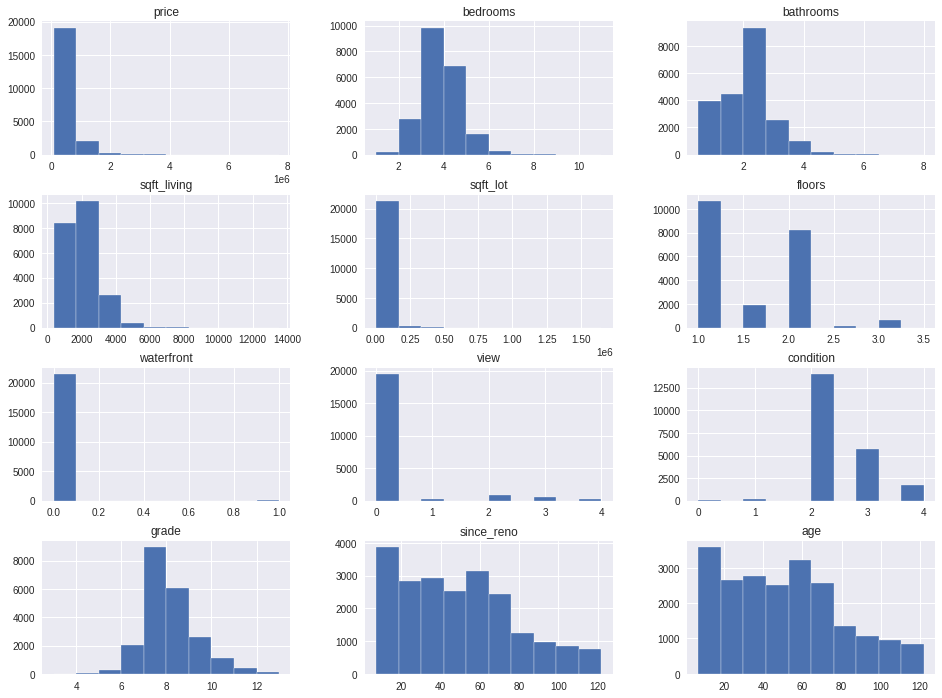

In [50]:
pd.plotting.hist_frame(homes,figsize=(16,12));

<h3>Correlations</h3>

Just a standard correlation coefficient matrix.

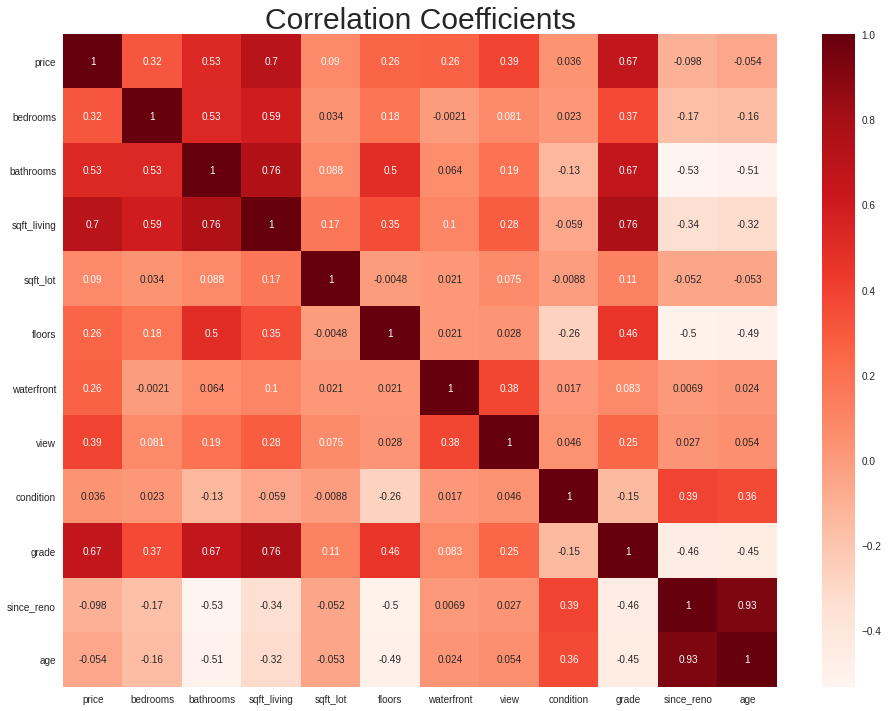

In [51]:
fig,ax = plt.subplots(figsize = (16,12))
ax.set_title('Correlation Coefficients',fontsize=30);
sns.heatmap(homes.corr(),annot=True,ax=ax,cmap='Reds');
ax.set_yticklabels(homes.columns,rotation=0);

<h3>Regression Plots</h3>

This takes a year and a half to run. This helps to visualize which variables have linear relationships with price.

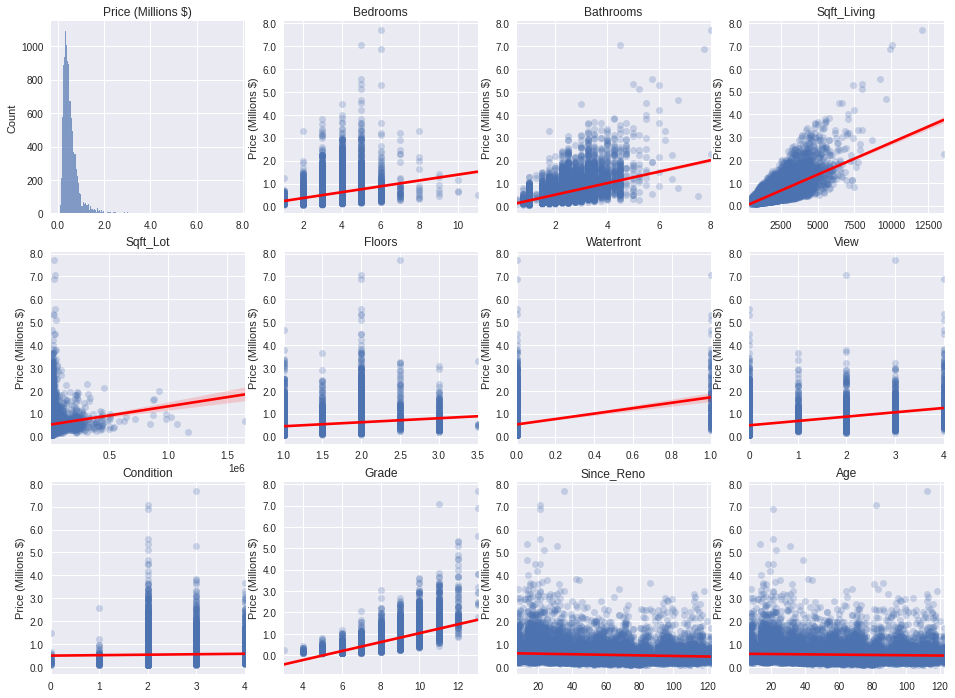

In [52]:
fig,ax = plt.subplots(3,4,figsize=(16,12))
for idx,row in enumerate(ax):
    for idx2,col in enumerate(row):
        y_val = homes.columns.values[(4*idx) + idx2]

        # Make a histogram for the price column
        if y_val == 'price':
            sns.histplot(homes.price,ax=col)
            col.set_title('Price (Millions $)')
            col.set_xticklabels(col.get_xticks()/1000000)
            col.set_xlabel('')
        # Make a scatter plot for all of the other columns
        else:
            sns.regplot(y='price',x=y_val,data=homes,ax=col,scatter_kws={'alpha':0.25},
                        line_kws={"color": "red"})
            col.set_title(y_val.title())
            col.set_yticklabels(col.get_yticks()/1000000)
            col.set_xlabel('')
            col.set_ylabel('Price (Millions $)')

<h3>Median Price by Location</h3>

Location has a huge impact on the price of a home, but has been left out of the plots so far. 

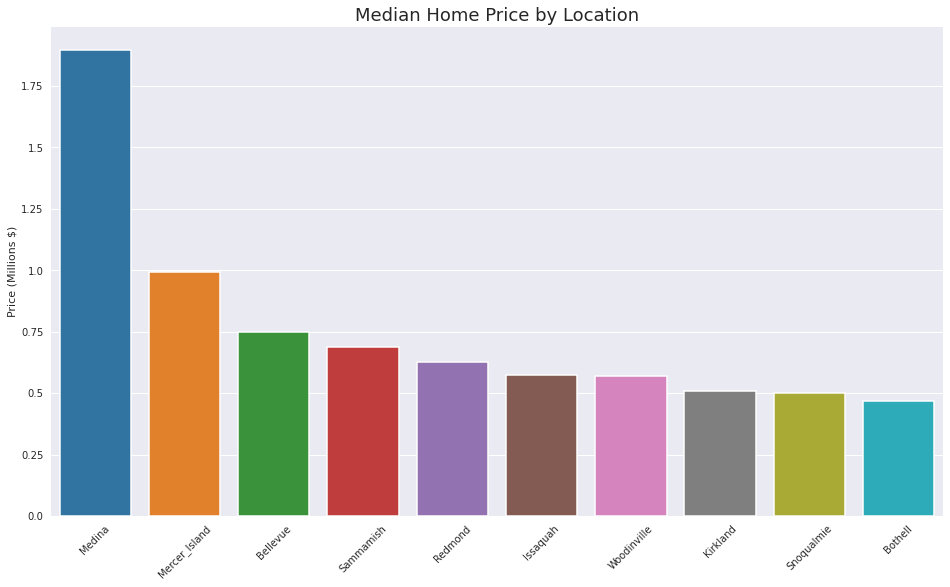

In [53]:
# Reshaping the data and taking only the first 10 cities for visibility
grouped_cities = pd.DataFrame(grouped_cities['price'].agg(np.median).sort_values(ascending=False)[:10]).T
fig,ax = plt.subplots(figsize = (16,9))
sns.set_theme(context='talk');
sns.barplot(data = grouped_cities,palette='tab10')
ax.set_xticklabels(grouped_cities.columns.values[:10], rotation = 45);
ax.set_yticklabels(ax.get_yticks()/1000000);
ax.set_title('Median Home Price by Location');
ax.set_ylabel('Price (Millions $)');
ax.set_xlabel('');

<hr>

<h1>Models</h1>

I start here by adding the encoded location data back to the main dataframe. This was kept separate earlier to keep the plots clean.

In [54]:
# Plotting is done so we can bring the encoded cities data back
homes = pd.concat([homes,cities],axis=1)

<h3>Basic Model</h3>

This is a very basic linear regression model that only used sqft_living to predict the price. 

In [55]:
X_basic = homes[['sqft_living']]
y_basic = homes.price

#Scaling the data so the coefficients are comparable
scaler_basic = StandardScaler()
X_scaled_basic = scaler_basic.fit_transform(X=X_basic,y=y_basic)
X_scaled_basic = pd.DataFrame(X_scaled_basic,columns=X_basic.columns)

X_scaled_basic = sm.add_constant(X_scaled_basic)

# Perform a train test split with the default size
# Random seed e = 2.71828
X_train_basic, X_test_basic, y_train_basic, y_test_basic\
     = train_test_split(X_scaled_basic,y_basic,random_state=271828)

# Create and fit linear regression and get summary
basic_regression = LinearRegression().fit(X_train_basic,y_train_basic)
basic_summary = model_summary(basic_regression,
                              X_train_basic,X_test_basic,y_train_basic,y_test_basic)
# Print summary statistics
basic_summary[0]

,Values
Train R2,0.488
Train Mean Abs Err,175043.731
Train Mean Sq Err,70579154795.151
Train Root Mean Sq Err,265667.376
Test R2,0.509
Test Mean Abs Err,171258.475
Test Mean Sq Err,62125867519.457
Test Root Mean Sq Err,249250.612


In [56]:
# Print coefficients
basic_summary[1].sort_values(by='Values',ascending=False)

,Values
sqft_living,259302.560
const,0.000


An R2 of around 0.5 for both train and test is not great and the RMSE is around $250,000. This means the model is off by a quarter of a million dollars on average. Not good!

<h3>Slightly Better Model</h3>

This is a better linear regression model that uses all of the available predictors to predict the housing price.

In [57]:
X_mid = homes.drop('price',axis=1)
y_mid = homes.price

scaler_mid = StandardScaler()
X_scaled_mid = scaler_mid.fit_transform(X=X_mid,y=y_mid)
X_scaled_mid = pd.DataFrame(X_scaled_mid,columns=X_mid.columns)

X_scaled_mid = sm.add_constant(X_scaled_mid)

# Perform a train test split with the default size
# Random seed e = 2.71828
X_train_mid, X_test_mid, y_train_mid, y_test_mid\
     = train_test_split(X_scaled_mid,y_mid,random_state=271828)

# Create and fit linear regression and get summary
mid_regression = LinearRegression().fit(X_train_mid,y_train_mid)
mid_summary = model_summary(mid_regression,
                              X_train_mid,X_test_mid,y_train_mid,y_test_mid)
# Print summary statistics
mid_summary[0]

,Values
Train R2,0.728
Train Mean Abs Err,120343.656
Train Mean Sq Err,37499863867.808
Train Root Mean Sq Err,193648.816
Test R2,0.762
Test Mean Abs Err,116574.837
Test Mean Sq Err,30129105775.133
Test Root Mean Sq Err,173577.377


In [58]:
# Print coefficients
mid_summary[1].sort_values(by='Values',ascending=False)

,Values
sqft_living,161404.841
grade,113241.238
city_Seattle,95183.422
age,87532.790
city_Bellevue,85803.122
city_Medina,58767.617
city_Kirkland,53127.830
city_Mercer_Island,50847.110
waterfront,49556.441
city_Redmond,42439.396


An R2 value of between 0.728 and 0.762 is pretty alright for this model. We even got the RMSE down to between $193,000 and $173,000. This is about $60,000 better than the previous model. We can still do better though.

<h3>Best I Could Do</h3>

This is the best linear regression model I could make that uses some of the available predictors to predict the housing price. It differs from the previous models in that I transform some of the data before I use it to make a prediction.

In [59]:
# These two features did not provide significant value in the previous model
homes.drop('sqft_lot',inplace=True,axis=1)
homes.drop('since_reno',inplace=True,axis=1)

# These predictors appear to be log normally distributed
homes.price = homes.price.apply(np.log)
homes.sqft_living = homes.sqft_living.apply(np.log)

In [60]:
X_best = homes.drop('price',axis=1)
y_best = homes.price

# Scaling the data this time
#scaler_best = StandardScaler()
#X_scaled_best = scaler_best.fit_transform(X=X_best,y=y_best)
#X_scaled_best = pd.DataFrame(X_scaled_best,columns=X_best.columns)

X_best = sm.add_constant(X_best)

# Perform a train test split with the default size
# Random seed e = 2.71828
X_train_best, X_test_best, y_train_best, y_test_best\
     = train_test_split(X_best,y_best,random_state=271828)

# Create and fit linear regression and get summary
best_regression = LinearRegression().fit(X_train_best,y_train_best)
best_summary = model_summary(best_regression,
                              X_train_best,X_test_best,y_train_best,y_test_best)

# Print summary statistics
best_summary[0]

,Values
Train R2,0.779
Train Mean Abs Err,0.187
Train Mean Sq Err,0.062
Train Root Mean Sq Err,0.248
Test R2,0.783
Test Mean Abs Err,0.183
Test Mean Sq Err,0.059
Test Root Mean Sq Err,0.244


In [61]:
# Print coefficients
best_summary[1].sort_values(by='Values',ascending=False)

,Values
city_Medina,1.178
city_Mercer_Island,0.777
city_Bellevue,0.685
city_Kirkland,0.594
city_Redmond,0.582
city_Sammamish,0.499
city_Issaquah,0.481
city_Fall_City,0.465
city_Seattle,0.464
city_Woodinville,0.444


This model got an R2 value between 0.779 and 0.783 which is pretty good. The rest of the factors are not super easy to interpret though because this model is predicting the natural log of the price of the house instead of the price directly. You can inverse the log to get good price predictions from this model, but it is less useful in analyzing the effects of each variable than the lase model.

<hr>

<h1>Comparing Model Predictions</h1>

The following graphs show the predictive power of each model. The ideal model would just show the line y=x where the predictions from the model are exactly the same as the actual home prices.

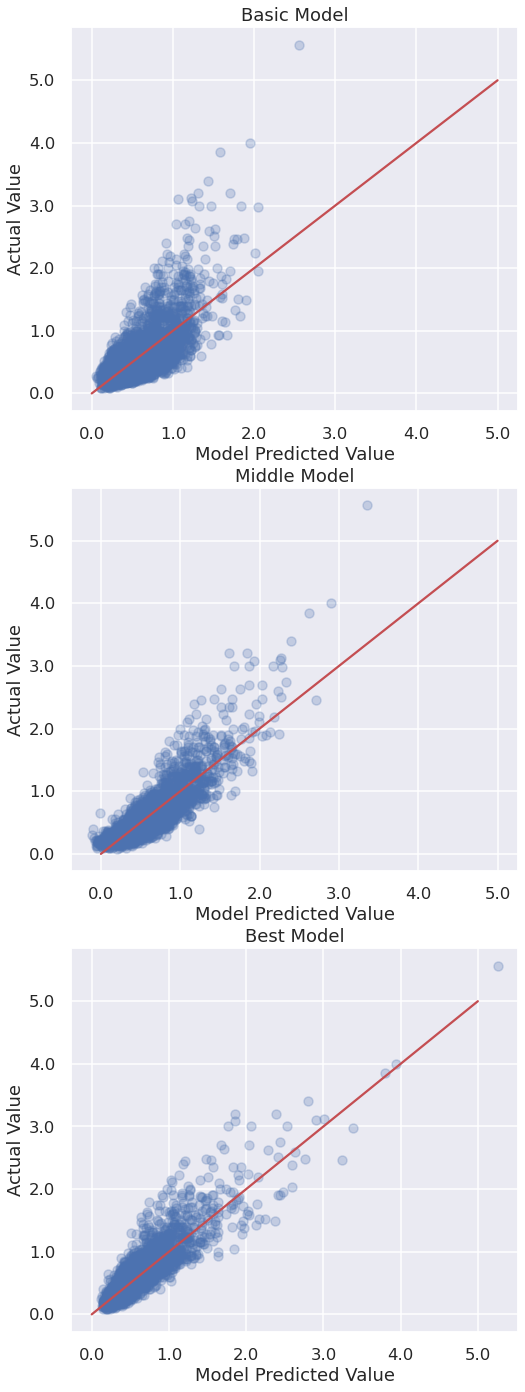

In [62]:
y_x = np.linspace(0,5e6,100)

# Generating predictions for each model
basic_pred = basic_regression.predict(X_test_basic)
mid_pred = mid_regression.predict(X_test_mid)
# This model predicts the log so we need to exponentiate
best_pred = np.exp(best_regression.predict(X_test_best))

fig,(ax1,ax2,ax3) = plt.subplots(3,figsize = (8,24))

# Plot for the basic model
ax1.scatter(basic_pred,y_test_basic,alpha=0.25)
ax1.plot(y_x,y_x,color='r')
ax1.set_title('Basic Model')

# Plot for the middle model
ax2.scatter(mid_pred,y_test_mid,alpha=0.25)
ax2.plot(y_x,y_x,color='r')
ax2.set_title('Middle Model')

# Plot for the third model
# This model predicts the log so we need to exponentiate
ax3.scatter(best_pred,np.exp(y_test_best),alpha=0.25)
ax3.plot(y_x,y_x,color='r')
ax3.set_title('Best Model')

for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('Model Predicted Value');
    ax.set_ylabel('Actual Value')
    ax.set_yticklabels(ax.get_yticks()/1000000);
    ax.set_xticklabels(ax.get_xticks()/1000000);

<hr>

<h1>Using Statsmodels</h1>

Statsmodels shows mostly the same information as the SKLearn models. It was mostly used for the confidence interval function at the top of this notebook and statistical information on my coefficients.

In [63]:
# Generate the regressions using the same data as from SKLearn
sm_basic = sm.OLS(y_train_basic,X_train_basic).fit()
sm_mid = sm.OLS(y_train_mid,X_train_mid).fit()
sm_best = sm.OLS(y_train_best,X_train_best).fit()

<h3>Basic Model</h3>

In [64]:
sm_basic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                 1.541e+04
Date:                Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:16:53   Log-Likelihood:            -2.2528e+05
No. Observations:               16197   AIC:                         4.506e+05
Df Residuals:                   16195   BIC:                         4.506e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.406e+05   2087.606    258.967      0.000    5.37e+05    5.45e+05
sqft_living  2.593e+05   2088.744    124.143      0.000    2.55e+05    2.63e+05
==============================================================================
Omnibus:                    11598.301   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           486196.505
Skew:                           2.965   Prob(JB):                         0.00
Kurtosis:                      29.178   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<h3>Slightly Better Model</h3>

In [65]:
sm_mid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     1271.
Date:                Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:16:53   Log-Likelihood:            -2.2016e+05
No. Observations:               16197   AIC:                         4.404e+05
Df Residuals:                   16162   BIC:                         4.407e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5.404e+05   1523.539    354.689      0.000    5.37e+05    5.43e+05
bedrooms           -3.701e+04   2008.667    -18.427      0.000    -4.1e+04   -3.31e+04
bathrooms           2.785e+04   2771.829     10.048      0.000    2.24e+04    3.33e+04
sqft_living         1.614e+05   3192.868     50.552      0.000    1.55e+05    1.68e+05
sqft_lot            2045.3660   1623.792      1.260      0.208   -1137.447    5228.179
floors              1.662e+04   1986.635      8.365      0.000    1.27e+04    2.05e+04
waterfront          4.956e+04   1657.552     29.897      0.000    4.63e+04    5.28e+04
view                3.317e+04   1770.952     18.728      0.000    2.97e+04    3.66e+04
condition           1.505e+04   1711.802      8.790      0.000    1.17e+04    1.84e+04
grade               1.132e+05   2716.668     41.684      0.000    1.08e+05    1.19e+05
since_reno         -1.786e+04   4196.327     -4.256      0.000   -2.61e+04   -9635.720
age                 8.753e+04   4176.321     20.959      0.000    7.93e+04    9.57e+04
city_Bellevue        8.58e+04   2398.625     35.772      0.000    8.11e+04    9.05e+04
city_Black_Diamond  5347.3252   1585.655      3.372      0.001    2239.265    8455.386
city_Bothell        1.058e+04   1637.897      6.457      0.000    7365.411    1.38e+04
city_Carnation      7983.6422   1640.045      4.868      0.000    4768.973    1.12e+04
city_Duvall         8351.4665   1659.447      5.033      0.000    5098.766    1.16e+04
city_Enumclaw       -125.1253   1728.488     -0.072      0.942   -3513.154    3262.904
city_Fall_City      9652.9279   1648.583      5.855      0.000    6421.523    1.29e+04
city_Federal_Way   -5959.0769   2022.277     -2.947      0.003   -9922.963   -1995.190
city_Issaquah       2.758e+04   2043.705     13.493      0.000    2.36e+04    3.16e+04
city_Kenmore        1.303e+04   1791.541      7.272      0.000    9516.020    1.65e+04
city_Kent           2827.7468   2247.717      1.258      0.208   -1578.027    7233.521
city_Kirkland       5.313e+04   2165.408     24.535      0.000    4.89e+04    5.74e+04
city_Maple_Valley   6111.2027   1931.416      3.164      0.002    2325.414    9896.991
city_Medina         5.877e+04   1583.538     37.112      0.000    5.57e+04    6.19e+04
city_Mercer_Island  5.085e+04   1744.843     29.141      0.000    4.74e+04    5.43e+04
city_North_Bend     9453.1477   1699.063      5.564      0.000    6122.796    1.28e+04
city_Redmond        4.244e+04   2165.701     19.596      0.000    3.82e+04    4.67e+04
city_Renton          1.74e+04   2431.316      7.159      0.000    1.26e+04    2.22e+04
city_Sammamish        2.7e+04   2099.489     12.861      0.000    2.29e+04    3.11e+04
city_Seattle        9.518e+04   3980.495     23.912      0.000    8.74e+04    1.03e+05
city_Snoqualmie     1.139e+04   1775.7

<h3>Best Model</h3>

In [66]:
sm_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     1777.
Date:                Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:16:53   Log-Likelihood:                -411.31
No. Observations:               16197   AIC:                             888.6
Df Residuals:                   16164   BIC:                             1142.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.6879      0.057    135.386      0.000       7.577       7.799
bedrooms              -0.0358      0.003    -12.111      0.000      -0.042      -0.030
bathrooms              0.0637      0.005     14.067      0.000       0.055       0.073
sqft_living            0.4230      0.010     43.799      0.000       0.404       0.442
floors                 0.0806      0.005     17.150      0.000       0.071       0.090
waterfront             0.3302      0.026     12.753      0.000       0.279       0.381
view                   0.0536      0.003     18.141      0.000       0.048       0.059
condition              0.0529      0.003     15.939      0.000       0.046       0.059
grade                  0.1706      0.003     58.986      0.000       0.165       0.176
age                    0.0036      0.000     36.188      0.000       0.003       0.004
city_Bellevue          0.6855      0.012     55.113      0.000       0.661       0.710
city_Black_Diamond     0.2720      0.030      9.103      0.000       0.213       0.331
city_Bothell           0.4096      0.022     18.464      0.000       0.366       0.453
city_Carnation         0.3381      0.028     12.292      0.000       0.284       0.392
city_Duvall            0.3282      0.023     14.421      0.000       0.284       0.373
city_Enumclaw          0.0481      0.021      2.254      0.024       0.006       0.090
city_Fall_City         0.4650      0.035     13.454      0.000       0.397       0.533
city_Federal_Way      -0.0453      0.014     -3.263      0.001      -0.073      -0.018
city_Issaquah          0.4814      0.014     33.283      0.000       0.453       0.510
city_Kenmore           0.3835      0.020     19.000      0.000       0.344       0.423
city_Kent              0.0378      0.013      3.004      0.003       0.013       0.062
city_Kirkland          0.5937      0.013     44.513      0.000       0.568       0.620
city_Maple_Valley      0.1708      0.015     11.237      0.000       0.141       0.201
city_Medina            1.1781      0.042     27.907      0.000       1.095       1.261
city_Mercer_Island     0.7767      0.020     39.461      0.000       0.738       0.815
city_North_Bend        0.3278      0.022     15.155      0.000       0.285       0.370
city_Redmond           0.5822      0.013     43.598      0.000       0.556       0.608
city_Renton            0.2298      0.012     19.313      0.000       0.207       0.253
city_Sammamish         0.4987      0.014     35.041      0.000       0.471       0.527
city_Seattle           0.4642      0.010     44.935      0.000       0.444       0.484
city_Snoqualmie        0.4057      0.019     21.145      0.000       0.368       0.443
city_Vashon            0.3392      0.028     12.159      0.000       0.285       0.394
city_Woodinville       0.4441      0.0

<hr>

<h1>Model Validation</h1>

There are three assumptions made when using a linear regression model.

<ol>
<li><b>Linearity</b>: Is there a linear relationship between the target and the predictors?</li>

We looked at this during the exploratory data analysis.

<li><b>Normality</b>: Are the residuals of the model normally distributed?</li>

We will look at this below.

<li><b>Homoscedasticity</b>: Does the variance of the residuals change based on the value of the target?</li>

We looked at this in the comparing model predictions section. It does appear that the residuals variance increases as price increases. I am not sure if this is statistically significant because I was unable to get the code for the Goldfeld-Quandt test working.

</ol>
    

<h2>Normality</h2>

The basic and medium models perform poorly in terms of normality of the residuals. The best model's residuals are pretty normally distributed however, only really deviating at the tails.

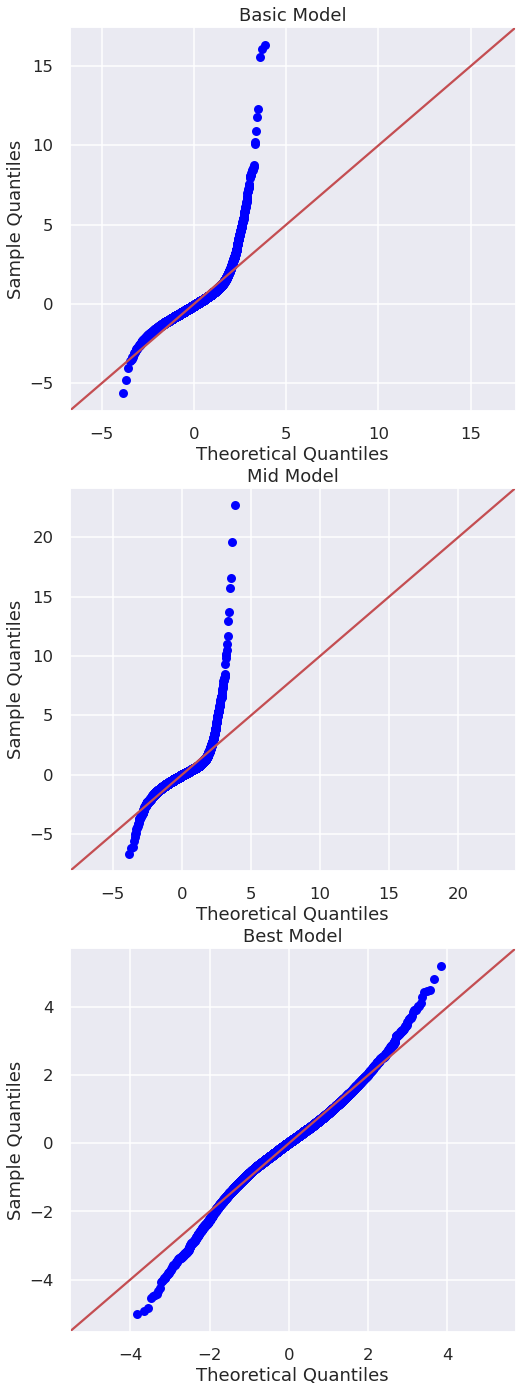

In [67]:
fig,(ax1,ax2,ax3) = plt.subplots(3,figsize = (8,24));

# Generate the three qq-plots
sm.graphics.qqplot(sm_basic.resid,dist=stats.norm, line='45', fit=True, ax = ax1)
ax1.set_title('Basic Model');

sm.graphics.qqplot(sm_mid.resid,dist=stats.norm, line='45', fit=True, ax = ax2)
ax2.set_title('Mid Model');

sm.graphics.qqplot(sm_best.resid,dist=stats.norm, line='45', fit=True, ax = ax3)
ax3.set_title('Best Model');

<hr>

<h1>Results</h1>

We were successful in creating a model that Bentley & Co. Bank can use to predict the price of a home given information about its features.

<ul>
<li>A linear regression model was appropriate for predicting home price using the provided dataset.</li>
<li>78 Percent of the variance in home price can be explained by the selected home features in the best model.</li>
</ul>

The following features proved to be the most important when predicting the price of a home:
<ol>
<li>Location</li>
<li>Grade</li>
<li>Living Area Square-Footage</li>
</ol>
 
 <b>I recommend that Bentley & Co. Bank use the best model for quick-and-dirty estimates of home price before a professional appraisal can be performed.</b>

  <b>I recommend that Bentley & Co. Bank use the best model to estimate the price impact of renovations on homes it has an interest in when an additional appraisal is not appropriate.</b>

 An example price prediction is shown below.

In [68]:
# Predict a random house from the test set's price
predict_interval(X_test_best.iloc[42],confidence=0.001);

This house has a predicted value of $663648.
A safe value for this house would fall between $640175 and $687982.
